# Target leakage example: classifying text data (tweets)

In this lab, we will load a new dataset from disk, clean it up and prepare it for training. The data here is of text type, as this is a dataset of 3000 tweets. So, we have to deal with short text inputs.

Each tweet has been written by one of two well-known individuals from the world of US politics. Our task is simply to decide who wrote it. Donald or Hillary?

<img src="figures/trump-clinton-split.jpg">

The first question here is: how do we deal with string inputs? We can't multiply a word by a weight, so we need to translate the text input in numbers before we proceed and feed it to our first layer. In this case, there are usually two options. The first is called "one-hot" encoding, where each word in a dictionary is translated to a vectors of ones and zeros. If there are 10 words in our dictionary (for example, the words are "zero", "one", "two" ... "nine"), each vector will contain ten elements, with nine elements set to zero and one set to one:

* "zero" -> [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
* "one"  -> [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
* "two"  -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
* ...
* "nine" -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

This is usually ok when dealing with text (or, more generically, "categorical") variables taken from a relatively small dictionary. In the case of tweets, we might be dealing with very a dictionary containing tens of thousands of different terms, so we would have huge inputs of sparse vectors of zeros and ones. This is not ideal.

The second option is to use word embeddings, which translate each word to a vector of floating points with some nice properties, as we can see in the following image:

<img src="figures/Word-Vectors.png">

Check out [this cool page](https://anvaka.github.io/pm/#/galaxy/word2vec-wiki?cx=-17&cy=-237&cz=-613&lx=-0.0575&ly=-0.9661&lz=-0.2401&lw=-0.0756&ml=300&s=1.75&l=1&v=d50_clean) visualizing embeddings calculated on the whole English dictionary for more examples.

Embeddings are done with a special NN layer that in Keras is called simply "Embedding" (https://keras.io/layers/embeddings/). The Embedding layer is provided with a number of text inputs (in our case, tweets) and learns to map similar words into n-dimensional vectors that are close together in the corresponding n-dimensional space.

In the following piece of code, we will start by loading the dataset with [pandas](https://pandas.pydata.org/docs/getting_started/intro_tutorials/index.html) and preparing it for training.

Notice how before we can use the Embedding layer, we want to map each word to an integer. This is because the input to an Embedding layer is actually a set of integers, where each integer represents a word. The important thing here, is that a given word has to be mapped always to the same integer throughout the whole dataset, so that the Embedding layer can recognise it from different tweets.

In this case, for example, the word "the" will always be mapped to the number 1, the word "question" to the number 2, etc.

* "The question is what to do"      -> [1, 2, 32, 55, 87]
* "I don't understand the question" -> [12, 4, 123, 1, 2]

Let's start by defining a helper function to plot training and validation curves:

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

def plot_loss_acc(history):
    try:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
    except:
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train acc', 'val acc', 'train loss', 'val loss'], loc='upper left')
    plt.show()

Download the dataset (uncomment and run)

In [ ]:
#!mkdir data/
#!wget -P data https://github.com/NBISweden/workshop-neural-nets-and-deep-learning/blob/961c3a45c3fd3603e6c31bac1c09f468c8e196bc/session_goodPracticesDatasetDesign/lab_targetLeakage/data/tweets.csv

Now let's load the dataset, which in this case is saved as CSV file, and let's print one tweet:

In [36]:
import pandas as pd

tweet_dataset = pd.read_csv("data/tweets.csv")

In [37]:
tweet_dataset.head()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27T23:45:00,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/t0...,{'media': [{'display_url': 'pic.twitter.com/t0...
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS,2016-09-27T23:26:40,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [{'id_str': '1536791610', 'n...",NaN
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27T23:08:41,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Q3...,{'media': [{'display_url': 'pic.twitter.com/Q3...
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27T22:30:27,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN


In [38]:
tweet_dataset["text"][0]

'The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG'

Then we apply a few basic operations to handle it more easily, for example:

* We add a space after every non-alphanumeric character so that we have, for example "-Hello" -> "- Hello"
* We make all words lower case, so that "Hello" == "hello"
* Lastly, we split each tweet by using space as delimiter, so that we have a list of words for each tweet

Then we assign a unique integer to each unique word in the dataset, so that we can translate each tweet to a list of numbers. But equal numbers will always correspond to equal words across all tweets! Notice how we reserve the integer "0" for "padding". This means that since the longest tweet has 58 words (so a list of 58 integers), we will add a series of "0"s to shorter tweets until they are also represented by a list of 58 integers.

Lastly, we assign to our labels (in this case the author of the tweets) one class between 0 and 1.

In [39]:
import numpy as np
import matplotlib.pyplot as plt

#Get rid of all retweets
print(tweet_dataset["text"][0])
tweet_dataset = tweet_dataset[tweet_dataset["is_retweet"] == False]
print(tweet_dataset["text"][0])

#Remove URLs
tweet_dataset["text"] = tweet_dataset["text"].str.replace('http\S+|www.\S+', '', case=False)
print(tweet_dataset["text"][0])


#Now let's make sure that non-alphanumeric characters are taken as single words
tweet_dataset["text"] = tweet_dataset["text"].str.replace('\s*([^a-zA-Z0-9 ])\s*', ' \\1 ', case=False)
print(tweet_dataset["text"][0])


#remove hashtags
#tweet_dataset["text"] = tweet_dataset["text"].str.replace('#[a-zA-Z0-9]*', '', case=False)

#remove @ mentions
#tweet_dataset["text"] = tweet_dataset["text"].str.replace('@[a-zA-Z0-9]*', '', case=False)

#make all words lower case?
tweet_dataset["text"] = tweet_dataset["text"].str.lower()
print(tweet_dataset["text"][0])


#split the tweets in list of words
tweet_dataset["text"] = tweet_dataset["text"].str.strip()
tweet_dataset["text"] = tweet_dataset["text"].str.split(" ")
print(tweet_dataset["text"][0])


#since the neural networks don't really like string inputs,
#we have to convert each word to a unique integer.
integer_dict = {}
integer_dict["padding"] = 0

word_dict = {}
word_dict[0] = "padding"

#assign a unique integer to each unique word
count = 1
for index, row in tweet_dataset.iterrows():
    for element in row["text"]:
        if element not in integer_dict.keys():

            integer_dict[element] = count
            word_dict[count] = element
            count += 1
    
tweet_dataset["numbers"] = tweet_dataset["text"].apply(lambda x:[integer_dict[y] for y in x])
print(tweet_dataset["text"][0])


#Let's also assign integer labels 
tweet_dataset.loc[tweet_dataset["handle"] == "realDonaldTrump","label"] = 1
tweet_dataset.loc[tweet_dataset["handle"] == "HillaryClinton","label"] = 0

#The longest tweet has 58 words, this will add padding to shorter tweets
train_x = pd.DataFrame(tweet_dataset["numbers"].values.tolist()).values
train_x[np.where(np.isnan(train_x[:]))] = 0

train_y = np.array(tweet_dataset["label"])
print(tweet_dataset["text"][0])



The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG
The question in this election: Who can put the plans into action that will make your life better? https://t.co/XreEY9OicG
The question in this election: Who can put the plans into action that will make your life better? 
The question in this election : Who can put the plans into action that will make your life better ? 
the question in this election : who can put the plans into action that will make your life better ? 
['the', 'question', 'in', 'this', 'election', ':', 'who', 'can', 'put', 'the', 'plans', 'into', 'action', 'that', 'will', 'make', 'your', 'life', 'better', '?']
['the', 'question', 'in', 'this', 'election', ':', 'who', 'can', 'put', 'the', 'plans', 'into', 'action', 'that', 'will', 'make', 'your', 'life', 'better', '?']


/home/hui_ubuntu/miniconda3/envs/nn_dl_python/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
/home/hui_ubuntu/miniconda3/envs/nn_dl_python/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app


['the', 'question', 'in', 'this', 'election', ':', 'who', 'can', 'put', 'the', 'plans', 'into', 'action', 'that', 'will', 'make', 'your', 'life', 'better', '?']


In [41]:
len(tweet_dataset["text"][0]), train_x.shape

(20, (5722, 58))

Check the effect that this has had on the first tweet:

In [45]:
for i in [0,3]:
    print(len(tweet_dataset["text"][i]))

20
24


In [21]:
for i in range(10):
    print(train_x[i].shape)

(58,)
(58,)
(58,)
(58,)
(58,)
(58,)
(58,)
(58,)
(58,)
(58,)


In [17]:
print(count)

8520


In [53]:
np.max(train_x)+1  #sum

8520.0

In [50]:
print(train_x[0],train_y[1])

[ 1.  2.  3.  4.  5.  6.  7.  8.  9.  1. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.] 0.0


Now, we will see how we can use Embeddings to transform our dictionary of words into a dictionary of float vectors.

First, let's use Embeddings, followed by Dense layers:

2024-05-22 11:18:10.464588: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-22 11:18:10.466049: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 11:18:10.468420: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-05-22 11:18:10.539489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-05-22 11:18:10.543270: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2496010000 Hz


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 58, 16)            136320    
_________________________________________________________________
flatten (Flatten)            (None, 928)               0         
_________________________________________________________________
dropout (Dropout)            (None, 928)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                9290      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 145,632
Trainable params: 145,632
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
144/144 [==============================] - 2s 11ms/step - loss: 0.6691 - accuracy: 0.5645 - val_loss: 0.5

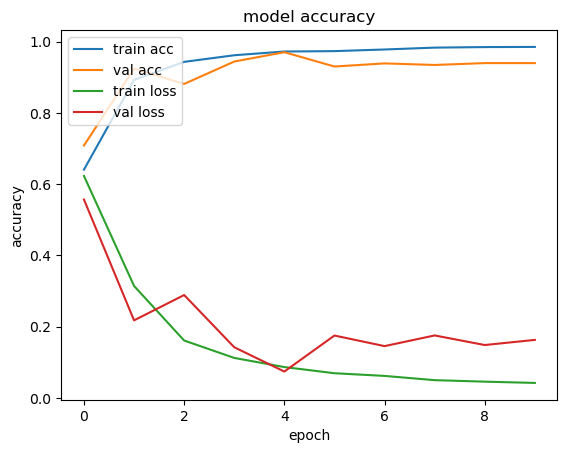

In [13]:
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout

model = Sequential()

model.add(Embedding(input_dim=count, output_dim=16, input_length=train_x.shape[1], name='embeddings'))
model.add(Flatten()) #Dense layers only accept 1D inputs, so we need to flatten the output from Embedding, which is 2D
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop',                    #adaptive learning rate method
              loss='sparse_categorical_crossentropy', #loss function for classification problems with integer labels
              metrics=['accuracy'])                   #the metric doesn't influence the training

hist = model.fit(train_x, train_y, epochs=10, batch_size=32, validation_split=0.2)

plot_loss_acc(hist)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 58, 16)            136320    
_________________________________________________________________
flatten_6 (Flatten)          (None, 928)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                29728     
_________________________________________________________________
dense_21 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 18        
Total params: 166,730
Trainable params: 166,730
Non-trainable params: 0
________________________________________________

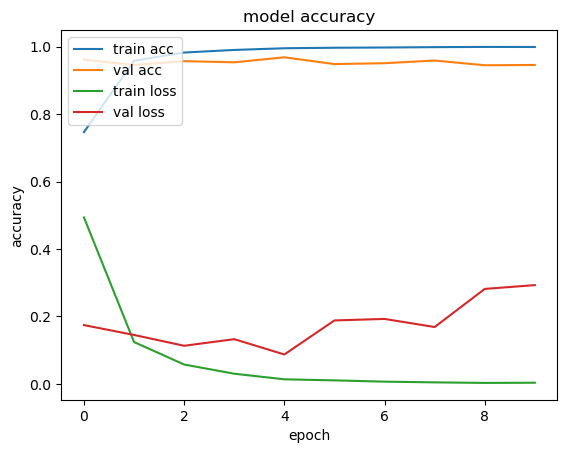

In [31]:
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout

model = Sequential()
model.add(Embedding(input_dim=count, output_dim=16, input_length=train_x.shape[1], name='embeddings'))
model.add(Flatten()) #Dense layers only accept 1D inputs, so we need to flatten the output from Embedding, which is 2D
# model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop',                    #adaptive learning rate method
              loss='sparse_categorical_crossentropy', #loss function for classification problems with integer labels
              metrics=['accuracy'])                   #the metric doesn't influence the training

hist = model.fit(train_x, train_y, epochs=10, batch_size=32, validation_split=0.2)

plot_loss_acc(hist)

In [ ]:
%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Dropout,Conv1D

model = Sequential()
model.add(Conv1D)
# input_dim vocabulary size
model.add(Embedding(input_dim=count, output_dim=16, input_length=train_x.shape[1], name='embeddings'))
model.add(Flatten()) #Dense layers only accept 1D inputs, so we need to flatten the output from Embedding, which is 2D
# model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop',                    #adaptive learning rate method
              loss='sparse_categorical_crossentropy', #loss function for classification problems with integer labels
              metrics=['accuracy'])                   #the metric doesn't influence the training

hist = model.fit(train_x, train_y, epochs=10, batch_size=32, validation_split=0.2)

plot_loss_acc(hist)

When a model has been trained, you can call the method `predict()` to get the predictions for all future samples. 
That is how you actually use your model when the job is done!

Can you think of a good dataset that you could use to test your model?

In [26]:
tweet = "at least 17 States have joined texas in the extraordinary case against the greatest Election"
tweet = tweet.lower()
words = tweet.split(" ")

tweet_integer = np.array([integer_dict[element] for element in words])

tweet_padded = np.zeros(58)
tweet_padded[:15] = tweet_integer

tweet_padded = tweet_padded[np.newaxis, :]
print(tweet_padded.shape)
result = model.predict(tweet_padded)

print(result)

(1, 58)
[[0.35460016 0.47792032]]


## Questions

* Which type of network works best?
* What could be a better network layer given the nature of this dataset?
* What is the meaning of the "count" variable used in the Embedding layer?
* Why does the last layer have 2 units? Why is the activation of the 'softmax' type?
* Play around with the hyperparameters, is there a way to improve the models?

Now let's visualize the outputs of the embedding layer. We extract the embedding layer from the trained model and we use it to calculate embeddings for every word in our dictionary. Then, we map the 32-dimensional output vector onto 2 dimensions with the help of principal component analysis (PCA).

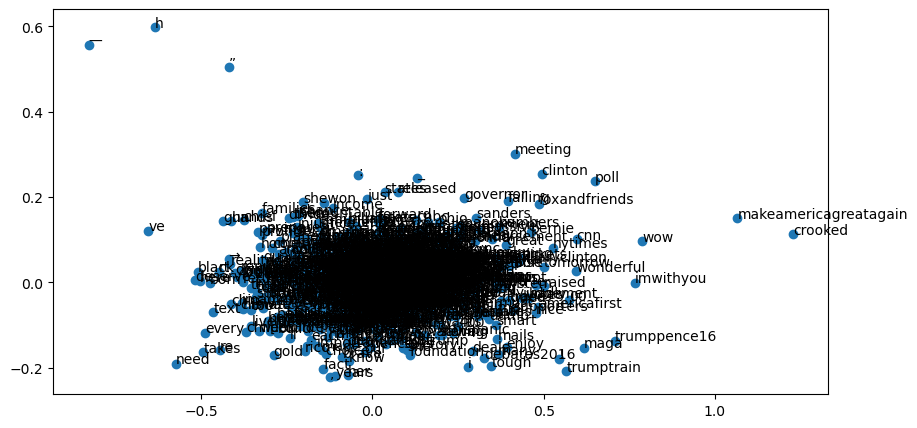

In [51]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import mpld3
mpld3.enable_notebook()

from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.pyplot import scatter
plt.rcParams['figure.figsize'] = [10, 5]

#extract the embeddings layer from the previous model, then use it as output in a new model
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('embeddings').output)

n_words = 1000
inputs = np.zeros((n_words, train_x.shape[1]))
for i in range(n_words):
    word = word_dict[i]
    for c in range(train_x.shape[1]):
        inputs[i, c] = i
    
intermediate_output = intermediate_layer_model.predict(inputs)

points = np.squeeze(intermediate_output[:,0,:])

pca = PCA(n_components=2, svd_solver='full')
points_pca = pca.fit_transform(points)

fig, ax = plt.subplots()
ax.scatter(points_pca[:,0], points_pca[:,1])

for i in range(n_words):
    ax.annotate(word_dict[i], (points_pca[i,0], points_pca[i,1]))

## Questions: what is wrong (or right) with this dataset?

* Take a few minutes to analyze the word cloud. Can you see what kind of words make the classification easier? If you wanted to make a less biased (and harder to classify) dataset, what would you change? 

* If possible, go back to the dataset generation step and remove words that make the classification task too easy. Then, try and train a new network. Are the results the same as before?

* Why do you think that the "Dense" network (Feed-forward, fully connected) works as well as the LSTM recurrent network on the dataset as it is now?

* Now that we have trained and validated our model, what would you suggest using as test set?

Here are a few examples of how the dataset can be manipulated. Try these lines of code (and come up with some others!) by pasting them in the right place the code block where the dataset is loaded (second code cell):

```python
#Get rid of all retweets
tweet_dataset = tweet_dataset[tweet_dataset["is_retweet"] == False]

#Next, let's remove all URLs, since they should not be of any help (unless we actually checked what they link to)
tweet_dataset["text"] = tweet_dataset["text"].str.replace('http\S+|www.\S+', '', case=False)

#remove hashtags
tweet_dataset["text"] = tweet_dataset["text"].str.replace('#[a-zA-Z0-9]*', '', case=False)

#Remove a word
tweet_dataset["text"] = tweet_dataset["text"].str.replace('crooked', '', case=False)

#Remove non-alphanumeric characters
tweet_dataset["text"] = tweet_dataset["text"].str.replace('\s*([^a-zA-Z0-9 ])\s*', '', case=False)

```